<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20ECG%20LSTM%20CNN%20Attention%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

ссылка на первоисточник данных ЭКГ:

https://www.physionet.org/content/mitdb/1.0.0/

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/MyDrive/edf_process/mitbih_train.csv'
file_path_test = '/content/drive/MyDrive/edf_process/mitbih_test.csv'

Mounted at /content/drive


In [3]:
import random

n = 100000 #number of records in file
s = 10000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

In [4]:
df_mitbih_train = pd.read_csv(file_path_train, header=None, skiprows=skip)
df_mitbih_test = pd.read_csv(file_path_test, header=None, skiprows=skip)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)


In [5]:
# датасет размечен на 5 классов
# в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={187: 'class'}, inplace=True)

df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

In [6]:
# добавим текстовое описание к размеченным классам
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 2116
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 15.7+ MB
None


In [48]:
# упростим задачу - переходим к бинарной классификации
id_to_label = {
    0: "Normal",     #0: "условно-здоровый"
    1: "Abnormal", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Abnormal", # "Преждевременное сокращение желудочков"
    3: "Abnormal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Abnormal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['healthy_status'] = df_mitbih.iloc[:, -2].map(id_to_label)
df_mitbih_test['healthy_status'] = df_mitbih_test.iloc[:, -2].map(id_to_label)
df_mitbih_train['healthy_status'] = df_mitbih_train.iloc[:, -2].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 2116
Columns: 190 entries, 0 to healthy_status
dtypes: float64(188), object(2)
memory usage: 15.8+ MB
None


In [72]:
from sklearn.utils import shuffle
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

df_mitbih_test.to_csv('/content/comp_ECG_fast_checkup_test.csv')
df_mitbih_train.to_csv('/content/comp_ECG_fast_checkup_train.csv')

In [73]:
df_mitbih_test.head()

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,class,label,healthy_status
0,1.000000,0.896000,0.756000,0.372000,0.236000,0.232000,0.216000,0.204000,0.200000,0.172000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
1,1.000000,0.885827,0.692913,0.452756,0.279528,0.177165,0.157480,0.161417,0.169291,0.173228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
2,0.869128,0.724832,0.402685,0.258389,0.147651,0.167785,0.161074,0.090604,0.167785,0.181208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
3,0.028409,0.125000,0.198864,0.437500,0.579545,0.721591,0.755682,0.772727,0.767045,0.795455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
4,1.000000,0.983936,0.889558,0.795181,0.722892,0.676707,0.648594,0.616466,0.526104,0.321285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Premature ventricular contraction,Abnormal


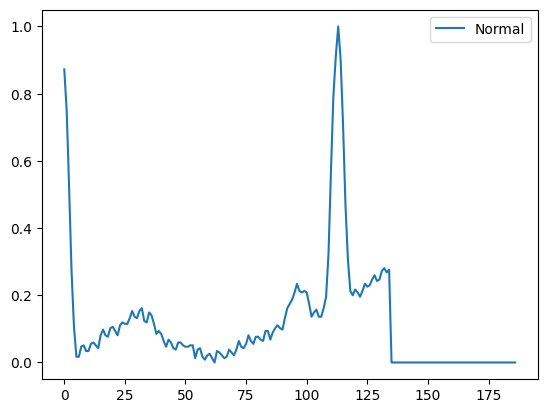

In [74]:
plt.plot(df_mitbih_train.iloc[0][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

In [75]:
df_mitbih['label'].value_counts()

,count
label,
Normal,8993
Fusion of paced and normal,770
Premature ventricular contraction,735
Artial Premature,264
Fusion of ventricular and normal,79


In [76]:
df_mitbih['healthy_status'].value_counts()

,count
healthy_status,
Normal,8993
Abnormal,1848


In [77]:
check_nan = df_mitbih[:].isnull().values.any()
print(check_nan)

False


In [79]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-3].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [80]:
#def get_dataloader(df, phase: str, batch_size: int = 96) -> DataLoader:
def get_dataloader(df, phase: str, batch_size: int = 96):

    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    #df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=123, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

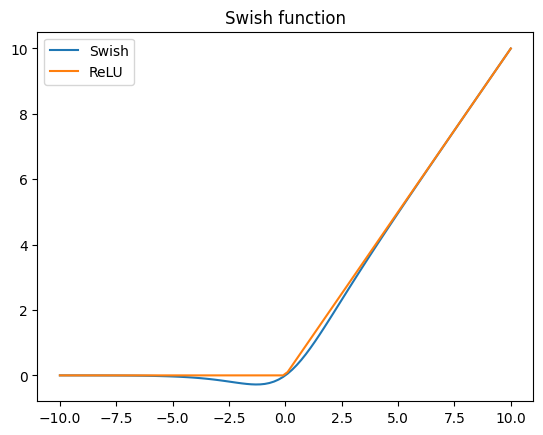

In [81]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

# NN Models

In [82]:
class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
        rnn_type = 'lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [83]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):

        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

In [84]:
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [85]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,#hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)#.squeeze(1)
        return x

In [86]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [87]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion

In [88]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        #self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        #self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase, net):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        #self.net.train() if phase == 'train' else self.net.eval()
        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            target = target.to(device)
            #data = data.to(config.device)
            #target = target.to(config.device)

            #output = self.net(data)
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self, net):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                #torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
                torch.save(net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()


# Modeling

In [89]:
#model = RNNAttentionModel(1, 64, 'lstm', bidirectional=False)
#model = RNNModel(input_size=1, hid_size=64, rnn_type='lstm', bidirectional=True)
model = CNN(num_classes=5, hid_size=64)

In [90]:
model._modules.items()
#model.state_dict()

dict_items([('conv1', ConvNormPool(
  (conv_1): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
  (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (conv_3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (swish_1): Swish()
  (swish_2): Swish()
  (swish_3): Swish()
  (normalization_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)), ('conv2', ConvNormPool(
  (conv_1): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
  (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (conv_3): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (swish_1): Swish()
  (swish_2): Swish()
  (swish_3): Swish()
  (normalization_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, 

In [91]:
trainer = Trainer(df=df_mitbih, net=model, lr=1e-3, batch_size=32, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train mode | time: 12:54:23


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 1.218565797556568, accuracy: 0.8101988966318234, f1: 0.47678940303090295, precision: 0.5952193591752627, recall: 0.7848721067469425


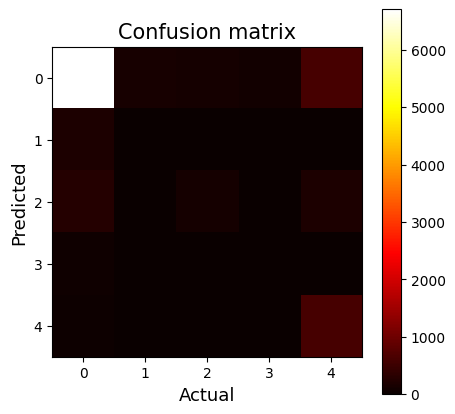

val mode | time: 12:55:02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 1.0382979893684388, accuracy: 0.920625, f1: 0.5419023305931175, precision: 0.5446944444444444, recall: 0.9853656188019022


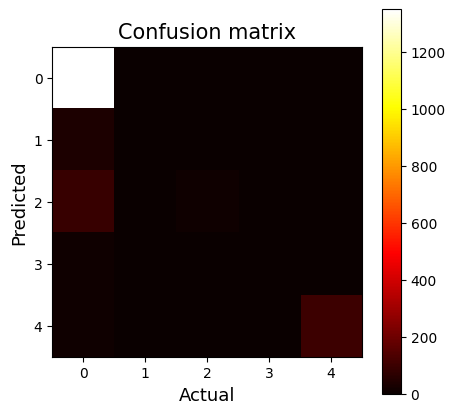


New checkpoint

train mode | time: 12:55:07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9984926649917709, accuracy: 0.9331228222996515, f1: 0.6773759871083241, precision: 0.6861887632546664, recall: 0.9504603738045803


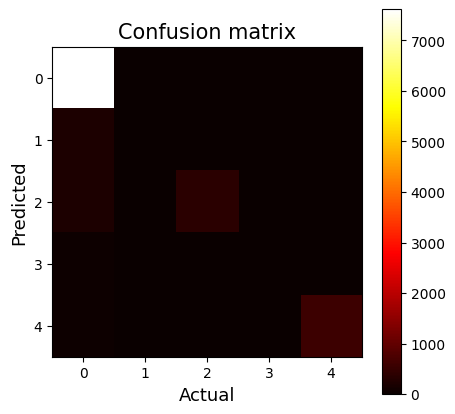

val mode | time: 12:55:48


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9989294731616973, accuracy: 0.959375, f1: 0.708128026304154, precision: 0.7175522317188985, recall: 0.9700405043948941


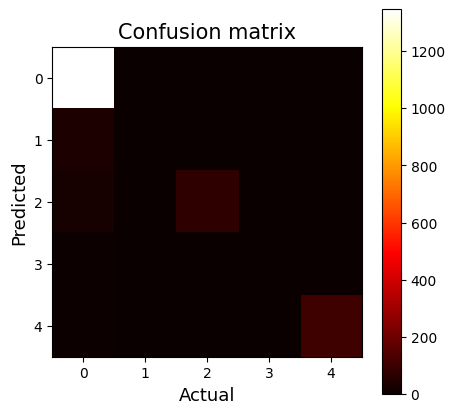


New checkpoint

train mode | time: 12:55:51


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9727345104832267, accuracy: 0.9483885017421603, f1: 0.7288159927509922, precision: 0.7372538489036937, recall: 0.956201749546752


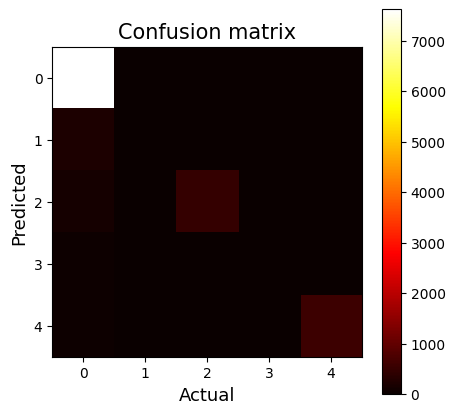

val mode | time: 12:56:29


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9777027702331543, accuracy: 0.968125, f1: 0.7399127859381583, precision: 0.7437316849816851, recall: 0.9812019270718335


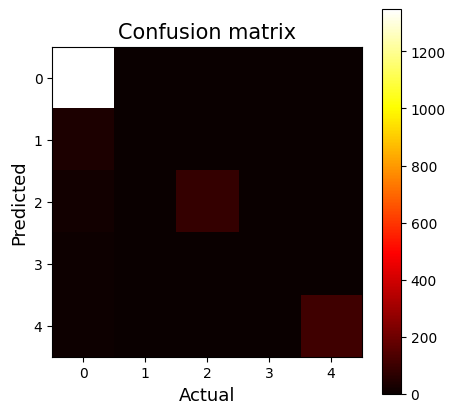


New checkpoint

train mode | time: 12:56:32


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9635295413097023, accuracy: 0.95448606271777, f1: 0.744679719723571, precision: 0.7587565636610152, recall: 0.9593935756959872


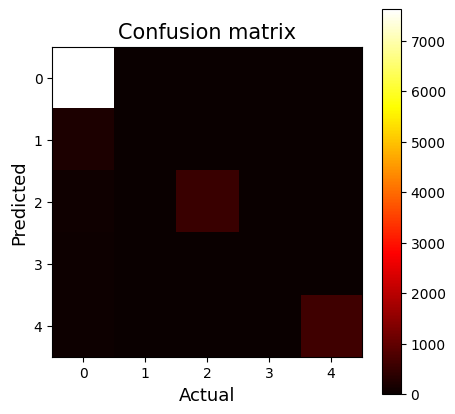

val mode | time: 12:57:12


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9758875524997711, accuracy: 0.970625, f1: 0.7461402893292606, precision: 0.7523983516483517, recall: 0.9841474147472065


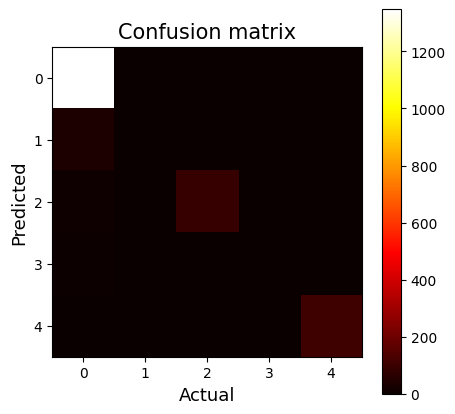


New checkpoint

train mode | time: 12:57:18


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9583234066331844, accuracy: 0.9576437282229965, f1: 0.7499101531428992, precision: 0.7667210145219869, recall: 0.9622667613830039


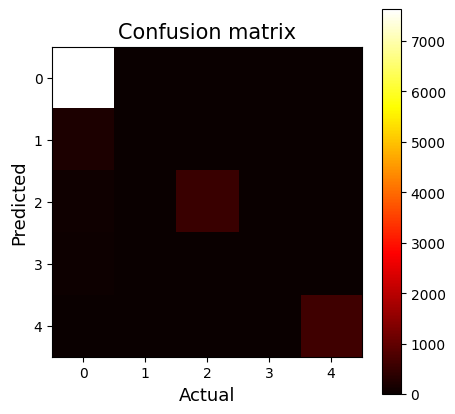

val mode | time: 12:57:56


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9742467963695526, accuracy: 0.97125, f1: 0.7478953775846584, precision: 0.7540650183150184, recall: 0.9841876762098818


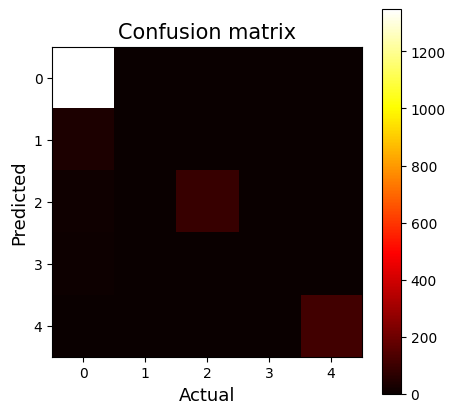


New checkpoint

train mode | time: 12:58:00


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9552790063598845, accuracy: 0.9597125435540069, f1: 0.757196293523595, precision: 0.770591189892723, recall: 0.9668101303550362


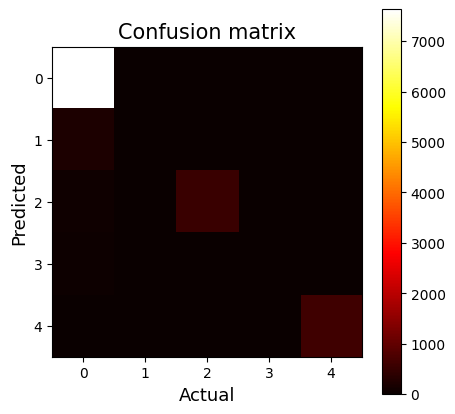

val mode | time: 12:58:38


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9725197696685791, accuracy: 0.970625, f1: 0.7471676794205936, precision: 0.7506666666666668, recall: 0.9871045533110007


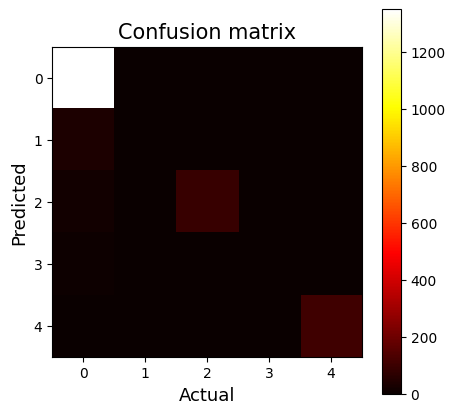


New checkpoint

train mode | time: 12:58:43


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9518071618645033, accuracy: 0.961890243902439, f1: 0.7625734181774677, precision: 0.7779621692233323, recall: 0.9681299096043322


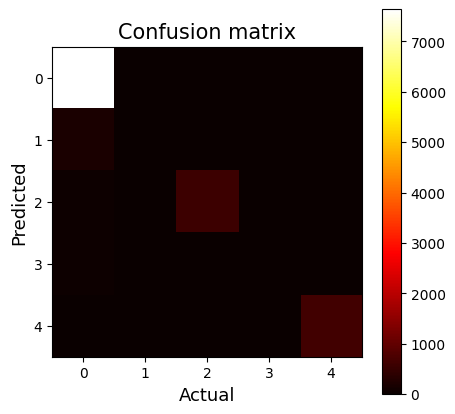

val mode | time: 12:59:22


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9702730321884155, accuracy: 0.97375, f1: 0.7549227078787888, precision: 0.761465811965812, recall: 0.9884829339534155


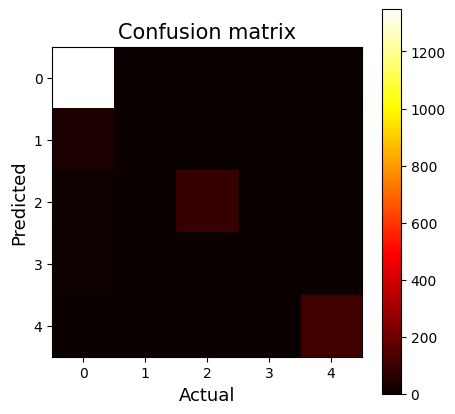


New checkpoint

train mode | time: 12:59:26


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9493173161450164, accuracy: 0.9639590592334495, f1: 0.7662567031698853, precision: 0.7833139350425777, recall: 0.967258337937405


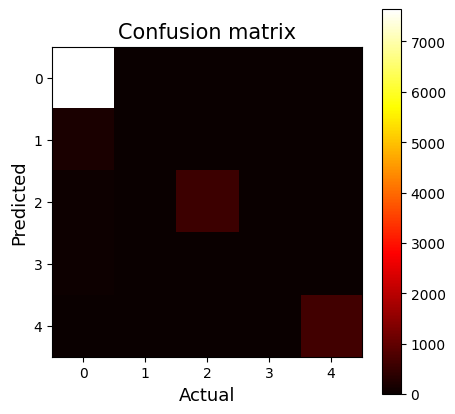

val mode | time: 13:00:03


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9688103544712067, accuracy: 0.975, f1: 0.7529187243035864, precision: 0.769620573870574, recall: 0.9760979383848454


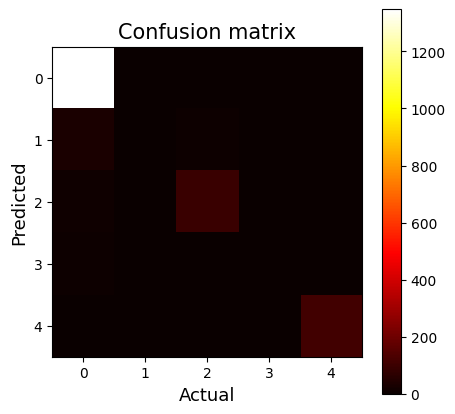

train mode | time: 13:00:07


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9473989227922951, accuracy: 0.9647212543554007, f1: 0.7664602352560754, precision: 0.7853367766995657, recall: 0.9645995794447461


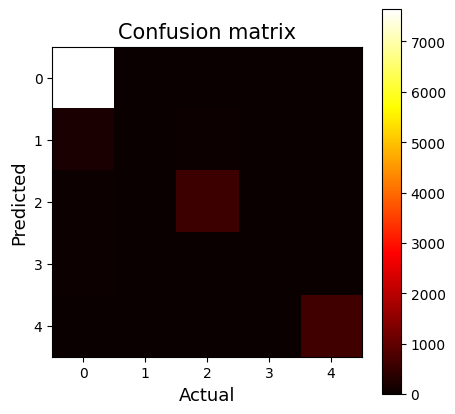

val mode | time: 13:00:53


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9680886614322662, accuracy: 0.975625, f1: 0.7549208627884737, precision: 0.7768427960927962, recall: 0.9703971352192664


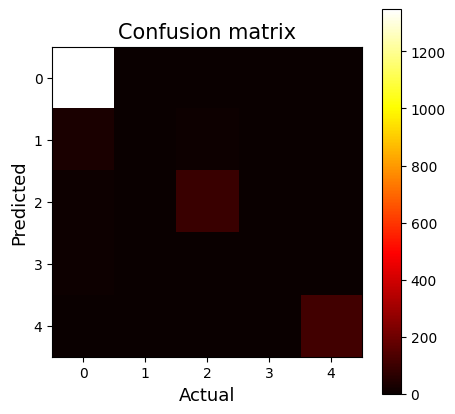

train mode | time: 13:00:56


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9460169324060765, accuracy: 0.9659189895470384, f1: 0.7691662186300557, precision: 0.7888529872279713, recall: 0.9664962028374933


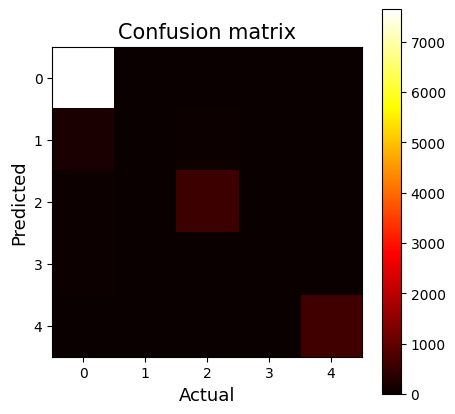

val mode | time: 13:01:41


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.9675106239318848, accuracy: 0.97625, f1: 0.7580010973681814, precision: 0.7824197191697192, recall: 0.968581750603882


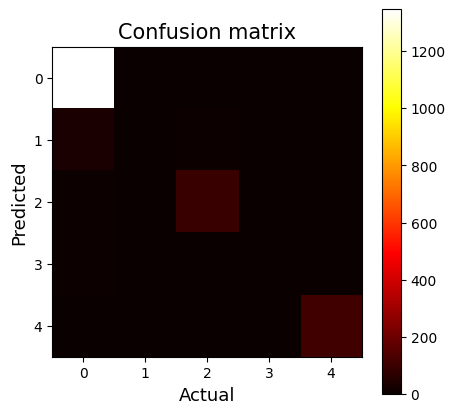

In [92]:
trainer.run(net=model)

In [93]:
model.eval()

CNN(
  (conv1): ConvNormPool(
    (conv_1): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
    (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (conv_3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (swish_1): Swish()
    (swish_2): Swish()
    (swish_3): Swish()
    (normalization_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (normalization_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (normalization_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvNormPool(
    (conv_1): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (conv_3): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (swish_1): Swish()
    (swish_2): Swish()
    (swish_3): Swish()
    (normalization_1): BatchNorm1d(32, eps=1e-05

In [94]:
train_logs = trainer.train_df_logs
train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

logs = pd.concat([train_logs,val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
                                 ]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,1.218566,1.038298,0.810199,0.920625,0.476789,0.541902,0.595219,0.544694,0.784872,0.985366
1,0.998493,0.998929,0.933123,0.959375,0.677376,0.708128,0.686189,0.717552,0.950460,0.970041
2,0.972735,0.977703,0.948389,0.968125,0.728816,0.739913,0.737254,0.743732,0.956202,0.981202
3,0.963530,0.975888,0.954486,0.970625,0.744680,0.746140,0.758757,0.752398,0.959394,0.984147
4,0.958323,0.974247,0.957644,0.971250,0.749910,0.747895,0.766721,0.754065,0.962267,0.984188


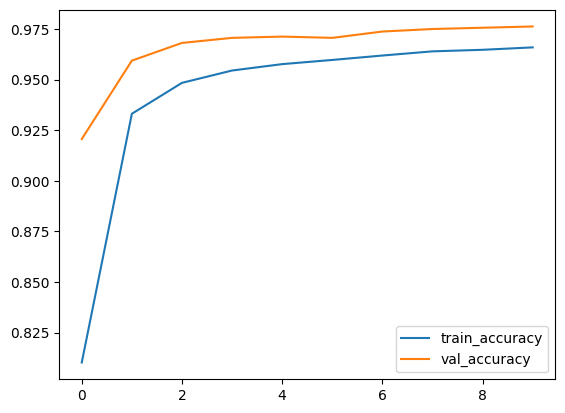

In [95]:
plt.plot(logs["train_accuracy"], label='train_accuracy')
plt.plot(logs["val_accuracy"], label='val_accuracy' )
plt.legend()
plt.show()

In [96]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [97]:
test_dataset = ECGDataset(df_mitbih_test)
print(df_mitbih_test.shape)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

(2117, 190)


<ipython-input-79-1c8c488dbad0>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])


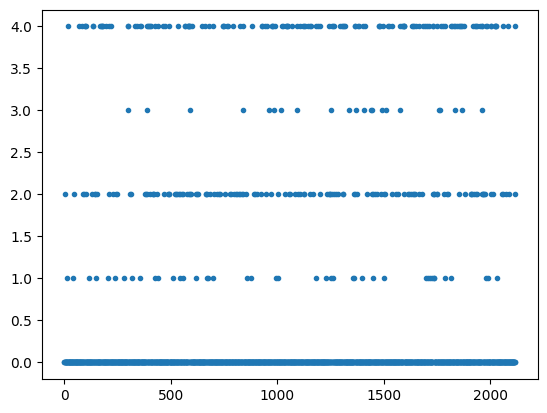

In [98]:
plt.plot(test_dataset[:][1],'.')

In [99]:
#models = [cnn_model, lstm_model, attn_model]
models = [model]

In [100]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

((2117,), (2117,))

In [103]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
0,0.999433,0.968132,0.983533,1820.0000
1,0.000000,0.000000,0.000000,0.0000
2,0.964029,0.899329,0.930556,149.0000
3,0.000000,0.000000,0.000000,0.0000
4,0.960265,0.979730,0.969900,148.0000
accuracy,0.964100,0.964100,0.964100,0.9641
macro avg,0.584745,0.569438,0.576798,2117.0000
weighted avg,0.994203,0.964100,0.978852,2117.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Ensemble Classification Report')

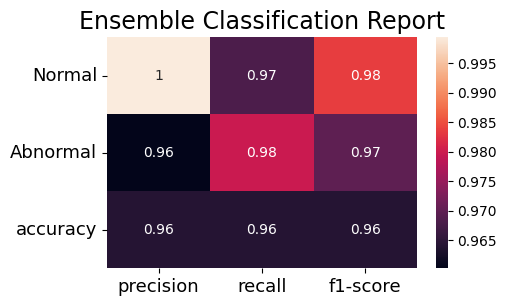

In [114]:
clf_report = classification_report(y_pred,
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),
                                   output_dict=True)


plt.figure(figsize=(5, 3))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=13, rotation=0)
plt.title("Ensemble Classification Report", fontsize=17)

#plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
#plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)